In [2]:
import idx2numpy
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
#Set device
#if cuda is available then use cuda, else use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
#declare parameters

input_size = 784 #image size = 28x28 --flatten 784
hidden_size = 1000
n_classes = 10
n_epoch = 2
batch_size = 100
learning_rate = 0.001

In [5]:
#unzip dataset to test_images, test_labels, train_images, train_labels as numpy

file = r'/home/zacharyyeh/Datasets/MNIST/t10k-images.idx3-ubyte'
test_images = idx2numpy.convert_from_file(file)
file = r'/home/zacharyyeh/Datasets/MNIST/t10k-labels.idx1-ubyte'
test_labels = idx2numpy.convert_from_file(file)
file = r'/home/zacharyyeh/Datasets/MNIST/train-images.idx3-ubyte'
train_images = idx2numpy.convert_from_file(file)
file = r'/home/zacharyyeh/Datasets/MNIST/train-labels.idx1-ubyte'
train_labels = idx2numpy.convert_from_file(file)

In [6]:
#Build children class TrainSet, TestSet from parent class Dataset 

class TrainSet(Dataset):
    def __init__(self, transform = None):
        self.train_images = train_images
        self.train_labels = train_labels
        self.n_samples = train_images.shape[0]
        #Important!!!! add a channel to images [28, 28] to [1, 28, 28] so that i can be seen as a image
        self.train_images = np.resize(self.train_images, (self.n_samples, 1, 28,28))
        self.transform = transform

    def __getitem__(self, index):
        output = self.train_images[index], self.train_labels[index]
        if self.transform:
            output = self.transform(output)
        return output

    def __len__(self):
        return self.n_samples

class TestSet(Dataset):
    def __init__(self, transform = None):
        self.test_images = test_images
        self.test_labels = test_labels
        self.n_samples = test_images.shape[0]
        self.test_images = np.resize(self.test_images, (self.n_samples, 1, 28,28))
        self.transform = transform

    def __getitem__(self, index):
        output = self.test_images[index], self.test_labels[index]
        if self.transform:
            output = self.transform(output)
        return output

    def __len__(self):
        return self.n_samples

#Make a Transform from numpy to tensor, Note: features and labels should be in differet dtype

class TensorTransform:
    def __call__(self, input):
        features, labels = input
        #features must be float type for foward pass(gradient calc), label tensor must be int(one-hot encoded)
        # if we use from_numpy, it thus inheret the dtype of desinated numpy, in this case, integer
        return torch.FloatTensor(features), torch.tensor(labels, dtype = int)

#Make dataset with transform included

train_dataset = TrainSet(transform = TensorTransform())
test_dataset = TestSet(transform = TensorTransform())

#Make dataloader

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

In [7]:
#Note:tensor and FloatTensor Treat arrays different, FloatTensor will force a dimension
a = np.array([1,2])
b = torch.tensor(a[0])
c = torch.FloatTensor(a[0])
print(a.shape)
print(b.shape)
print(c.shape)

(2,)
torch.Size([])
torch.Size([1])


<class 'torch.Tensor'> torch.Size([100])


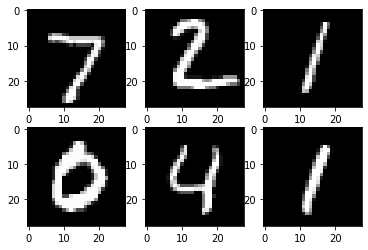

In [8]:
#Show some examples to examinate dataloader

examples = iter(test_loader)
example_data, example_targets = examples.next()
print(type(example_targets), example_targets.shape)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [9]:
#Build a Fully connected Neural Network

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes):
        super(Model, self).__init__()
        self.Linear1 = nn.Linear(input_size, hidden_size)
        self.ReLU = nn.ReLU()
        self.Linear2 = nn.Linear(hidden_size, n_classes)
        #we don't have to do softmax here, because we are use CrossEntropy, which softmax is included
    def forward(self, x):
        output = self.Linear1(x)
        output = self.ReLU(output)
        output = self.Linear2(output)
        return output

model = Model(input_size = input_size, hidden_size = hidden_size, n_classes = n_classes).to(device)

print(model)

Model(
  (Linear1): Linear(in_features=784, out_features=1000, bias=True)
  (ReLU): ReLU()
  (Linear2): Linear(in_features=1000, out_features=10, bias=True)
)


In [10]:
#Define loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [11]:
#Make Training Loop

steps = len(train_loader)

print('Start training...')

for epoch in range(n_epoch):
    for i, (images, labels) in enumerate(train_loader):
        #first, we flatten our image to fit model input, and move it to GPU
        #[100, 1, 28, 28] to [100, 784]
        #reshape(dimention, desinated size)
        #reshape function change array to dimention = dimention to fit the desinated size
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        #forward pass
        pred_labels = model(images)
        loss = criterion(pred_labels, labels)

        #backward pass
        loss.backward()

        #update gradients
        optimizer.step()
        optimizer.zero_grad()

        #print information in a epoch
        if (i+1) % 100 == 0:
            print(f'epoch: {epoch+1}/{n_epoch}, step: {(i+1)}/{steps}, loss: {loss.item():.3f}')

            
print('Training is completed')

Start training...
epoch: 1/2, step: 100/600, loss: 0.170
epoch: 1/2, step: 200/600, loss: 0.170
epoch: 1/2, step: 300/600, loss: 0.148
epoch: 1/2, step: 400/600, loss: 0.106
epoch: 1/2, step: 500/600, loss: 0.047
epoch: 1/2, step: 600/600, loss: 0.131
epoch: 2/2, step: 100/600, loss: 0.053
epoch: 2/2, step: 200/600, loss: 0.112
epoch: 2/2, step: 300/600, loss: 0.237
epoch: 2/2, step: 400/600, loss: 0.173
epoch: 2/2, step: 500/600, loss: 0.180
epoch: 2/2, step: 600/600, loss: 0.087
Training is completed


In [12]:
#Test the model

#Note: In test case, we do not want to calculate the gradients
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    #you can also use for i, (images, labels) in enumerate(test_loader):
    #but now we don't care batch imformation, simple use this
    for images, labels in test_loader:
        #flatten
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        output = model(images)
        #the output is a probability distribution. We want to tranform them into integer(predicted state)
        #torch.max(tensor, dimention) will return [max tensor value, index] in a dimention of a tensor
        #here we only want the index, not the linear output(float), actually it is the predicted number
        #Note: _ here is not probability because we didn't apply softmax
        _, predicted = torch.max(output, 1)
        n_samples = n_samples + labels.shape[0]
        #Note (predicted == labels) is still a tensor with one element. We need to use item() to get a value
        #then we can compute divition
        n_correct = n_correct + (predicted == labels).sum().item()

acc = n_correct / n_samples
print(f'model accuracy: {acc:.3f}')

model accuracy: 0.945
